The objective of this work is to develop a complete predictive modeling pipeline using the Canine Wellness Dataset (Synthetic). Comparing the K-Nearest Neighbors (KNN) and Random Forest algorithms to identify which one performs best in the proposed classification problem.

The work involves: data exploration and preprocessing, application of sampling techniques, model construction and evaluation, statistical analysis to compare classifiers, and definition of a deployment strategy for the winning model.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
input_file = 'synthetic_dog_breed_health_data.csv' 

# --- 1. Cargar archivo ---
df = pd.read_csv(input_file)
df =df.drop(columns=["ID"], errors = "ignore")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Breed                        9710 non-null   object 
 1   Breed Size                   9712 non-null   object 
 2   Sex                          9675 non-null   object 
 3   Age                          9709 non-null   float64
 4   Weight (lbs)                 9709 non-null   float64
 5   Spay/Neuter Status           6433 non-null   object 
 6   Daily Activity Level         7770 non-null   object 
 7   Diet                         9698 non-null   object 
 8   Food Brand                   9700 non-null   object 
 9   Daily Walk Distance (miles)  9706 non-null   float64
 10  Other Pets in Household      9702 non-null   object 
 11  Medications                  9751 non-null   object 
 12  Seizures                     9699 non-null   object 
 13  Hours of Sleep   

,Breed,Breed Size,Sex,Age,Weight (lbs),Spay/Neuter Status,Daily Activity Level,Diet,Food Brand,Daily Walk Distance (miles),Other Pets in Household,Medications,Seizures,Hours of Sleep,Play Time (hrs),Owner Activity Level,Annual Vet Visits,Average Temperature (F),Synthetic,Healthy
0,Australian Shepherd,Medium,Male,3.0,60.0,Neutered,NaN,NaN,Wellness,5.0,No,Yes,No,12.0,1.0,Active,1.0,30.0,Yes,Yes
1,Dachshund,NaN,Female,4.0,57.0,Neutered,Very Active,Home cooked,Special,2.0,Yes,No,No,11.0,3.0,NaN,0.0,47.0,Yes,NaN
2,Chihuahua,Small,Female,12.0,67.0,Neutered,Active,Home cooked,Special,1.0,Yes,No,No,10.0,1.0,Low,0.0,92.0,Yes,Yes
3,Siberian Husky,Medium,Male,13.0,35.0,NaN,Very Active,NaN,Special,4.0,No,No,No,12.0,NaN,NaN,1.0,75.0,Yes,Yes
4,Boxer,Medium,Male,13.0,35.0,NaN,Very Active,Wet food,Purina,3.0,Yes,Yes,No,9.0,1.0,NaN,0.0,64.0,Yes,No


**Exploratory**

In this section, we will explore and analyze the data contained in the dataset.

In [3]:
# --- CONFIGURATION ---
#input_file = 'synthetic_dog_breed_health_data.csv'         # your original file
output_file = "dataset_all.csv"    # cleaned file


# --- 1. Load file ---
#df = pd.read_csv(input_file,index_col= 0)


# --- 2. Clean column names ---
def clean_column_name(col):
    # Replace spaces with underscores
    col = col.replace(" ", "_")
    # Remove parentheses and other problematic characters
    col = re.sub(r"[^\w_]", "", col)
    return col


df.columns = [clean_column_name(c) for c in df.columns]


# --- 3. Clean values with spaces or special characters ---
def clean_value(val):
    if isinstance(val, str):
        # Replace spaces with underscores in values
        val = val.strip().replace(" ", "_")
        # Remove strange characters
        val = re.sub(r"[^\w_.-]", "", val)
    return val


df = df.map(clean_value)


# --- 4. Save cleaned file ---
df.to_csv(output_file, index=False)


print("Clean file generated:", output_file)


Clean file generated: dataset_all.csv


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Breed                      9710 non-null   object 
 1   Breed_Size                 9712 non-null   object 
 2   Sex                        9675 non-null   object 
 3   Age                        9709 non-null   float64
 4   Weight_lbs                 9709 non-null   float64
 5   SpayNeuter_Status          6433 non-null   object 
 6   Daily_Activity_Level       7770 non-null   object 
 7   Diet                       9698 non-null   object 
 8   Food_Brand                 9700 non-null   object 
 9   Daily_Walk_Distance_miles  9706 non-null   float64
 10  Other_Pets_in_Household    9702 non-null   object 
 11  Medications                9751 non-null   object 
 12  Seizures                   9699 non-null   object 
 13  Hours_of_Sleep             9721 non-null   floa

In [5]:
conteo = df['Healthy'].value_counts()
print("Null values:", df["Healthy"].isnull().sum())
conteo

Null values: 322


Healthy
Yes    7178
No     2500
Name: count, dtype: int64

It is observed that there are null values in the target variable. These cases of null values will be eliminated after imputation in order to make use of as much data as possible.

In [6]:
df = pd.read_csv("dataset_all.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Breed                      9710 non-null   object 
 1   Breed_Size                 9712 non-null   object 
 2   Sex                        9675 non-null   object 
 3   Age                        9709 non-null   float64
 4   Weight_lbs                 9709 non-null   float64
 5   SpayNeuter_Status          6433 non-null   object 
 6   Daily_Activity_Level       7770 non-null   object 
 7   Diet                       9698 non-null   object 
 8   Food_Brand                 9700 non-null   object 
 9   Daily_Walk_Distance_miles  9706 non-null   float64
 10  Other_Pets_in_Household    9702 non-null   object 
 11  Medications                9751 non-null   object 
 12  Seizures                   9699 non-null   object 
 13  Hours_of_Sleep             9721 non-null   floa

Let's analyze the attributes of the dataset.

In [7]:
df_columns = df.columns.tolist()
df_columns
results_nulls = {}
for i in df_columns:

    if df[i].dtype == 'float64':
        print(i, "[numerical]")

    else:
        print(i, df[i].unique())

    valor_nulo = df[i].isnull().sum()
    results_nulls[i] = valor_nulo
    print('Null values:', valor_nulo )

# We sort the dictionary using the values
results_nulls = dict(sorted(results_nulls.items(), key=lambda item: item[1], reverse=True))

Breed ['Australian_Shepherd' 'Dachshund' 'Chihuahua' 'Siberian_Husky' 'Boxer'
 'Labrador_Retriever' 'Bulldog' 'Rottweiler' 'German_Shepherd'
 'Golden_Retriever' 'Poodle' 'Doberman' 'Great_Dane' 'Beagle'
 'Yorkshire_Terrier' nan]
Null values: 290
Breed_Size ['Medium' nan 'Small' 'Large']
Null values: 288
Sex ['Male' 'Female' nan]
Null values: 325
Age [numerical]
Null values: 291
Weight_lbs [numerical]
Null values: 291
SpayNeuter_Status ['Neutered' nan 'Spayed']
Null values: 3567
Daily_Activity_Level [nan 'Very_Active' 'Active' 'Moderate' 'Low']
Null values: 2230
Diet [nan 'Home_cooked' 'Wet_food' 'Special_diet' 'Hard_food']
Null values: 302
Food_Brand ['Wellness' 'Special' 'Purina' 'Iams' 'Blue_Buffalo' 'Royal_Canin' 'Nutro'
 'Pedigree' 'Hills_Science' nan]
Null values: 300
Daily_Walk_Distance_miles [numerical]
Null values: 294
Other_Pets_in_Household ['No' 'Yes' nan]
Null values: 298
Medications ['Yes' 'No' nan]
Null values: 249
Seizures ['No' 'Yes' nan]
Null values: 301
Hours_of_Sleep

Now we check the number of null values in each column.

SpayNeuter_Status 3567
Daily_Activity_Level 2230
Owner_Activity_Level 2227
Average_Temperature_F 345
Sex 325
Healthy 322
Synthetic 310
Play_Time_hrs 309
Annual_Vet_Visits 306
Diet 302
Seizures 301
Food_Brand 300
Other_Pets_in_Household 298
Daily_Walk_Distance_miles 294
Age 291
Weight_lbs 291
Breed 290
Breed_Size 288
Hours_of_Sleep 279
Medications 249


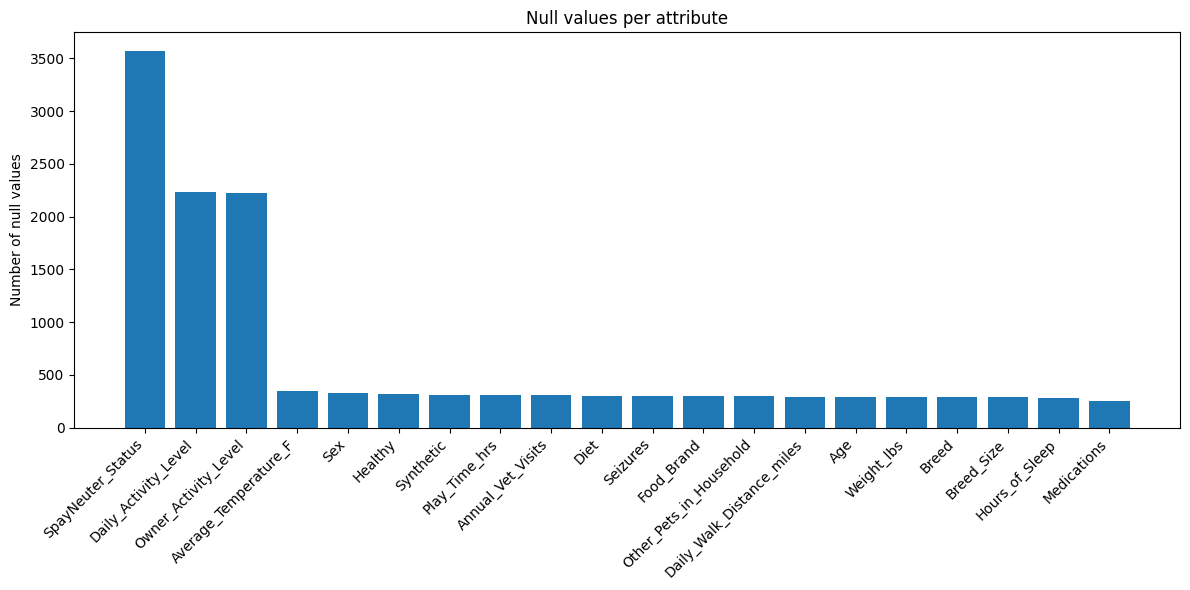

In [8]:
for clave, valor in results_nulls.items():
    print(clave,valor)

# Extract keys and values
columnas = list(results_nulls.keys())
nulos = list(results_nulls.values())

plt.figure(figsize=(12, 6))
plt.bar(columnas, nulos)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of null values")
plt.title("Null values per attribute")

plt.tight_layout()
plt.show()

*We can see that the critical columns to be addressed due to the number of null values are the following columns:*

- SpayNeuter_Status
- Daily_Activity_Level
- Owner_Activity_Level

*These null values are unknown, so we will fill in these missing values by creating an Unknown category.*

*We will also fill in the null values for the Breed attribute with Unknown so as not to lose the information contained in those cases.*

*We discard the ‘Synthetic’ attribute as it only has one value.*

In [9]:
# 1. Imputation of variables with MANY null values (>2000)
# We create an explicit category so as not to introduce noise
cols_high_nulls = ['SpayNeuter_Status', 'Daily_Activity_Level', 'Owner_Activity_Level', 'Breed']
for col in cols_high_nulls:
    df[col] = df[col].fillna('Unknown')

# We are dropping the Synthetic column.

df.drop('Synthetic', axis=1, inplace=True)

*Hypothesis: The Weight attribute is correlated with the Breed_Size attribute*

Let's verify this and, if the hypothesis is correct, we will fill in the null values for Breed_size with the values for Weight.

To do this, we should observe that the larger the breed size, the higher the average weight.

C:\Users\bruan\AppData\Local\Temp\ipykernel_19756\1981645844.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


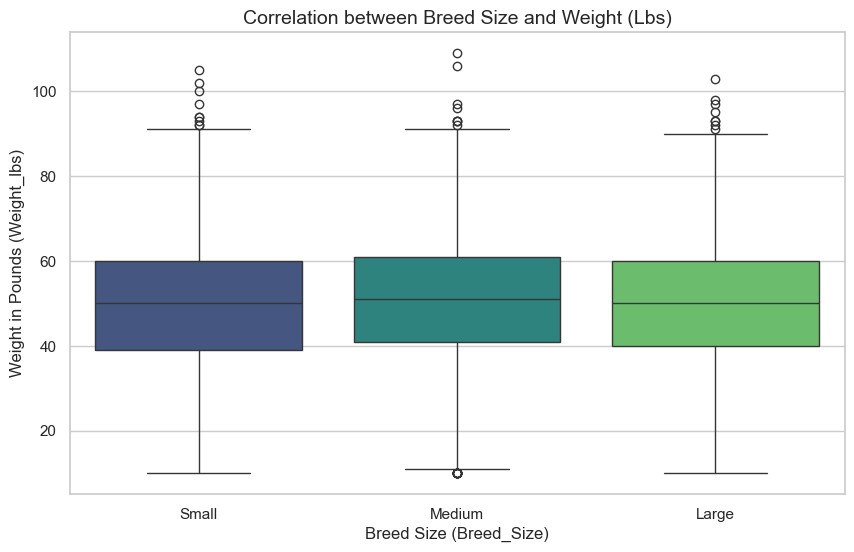

In [10]:
import seaborn as sns


# 1. Configure the plot style
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")


# 2. Define the logical order of categories to keep the plot readable
order_sizes = ['Small', 'Medium', 'Large']


# 3. Create the box plot
# This shows the median, quartiles, and outliers of weight for each size
sns.boxplot(
    data=df, 
    x='Breed_Size', 
    y='Weight_lbs', 
    order=order_sizes,
    palette="viridis"
)


# 4. Add title and labels
plt.title('Correlation between Breed Size and Weight (Lbs)', fontsize=14)
plt.xlabel('Breed Size (Breed_Size)', fontsize=12)
plt.ylabel('Weight in Pounds (Weight_lbs)', fontsize=12)


# 5. Show the plot
plt.show()


*False hypothesis!*

There is no correlation between the values for weight and breed size.

Now, since the Breed_Size attribute does not reflect a real characteristic, this attribute does not contribute predictive value to the model, so we will discard the attribute from the dataset.

In [11]:
df.drop(['Breed_Size'], axis=1, inplace=True)

*Now we are going to plot the numerical values to visualize their distribution*

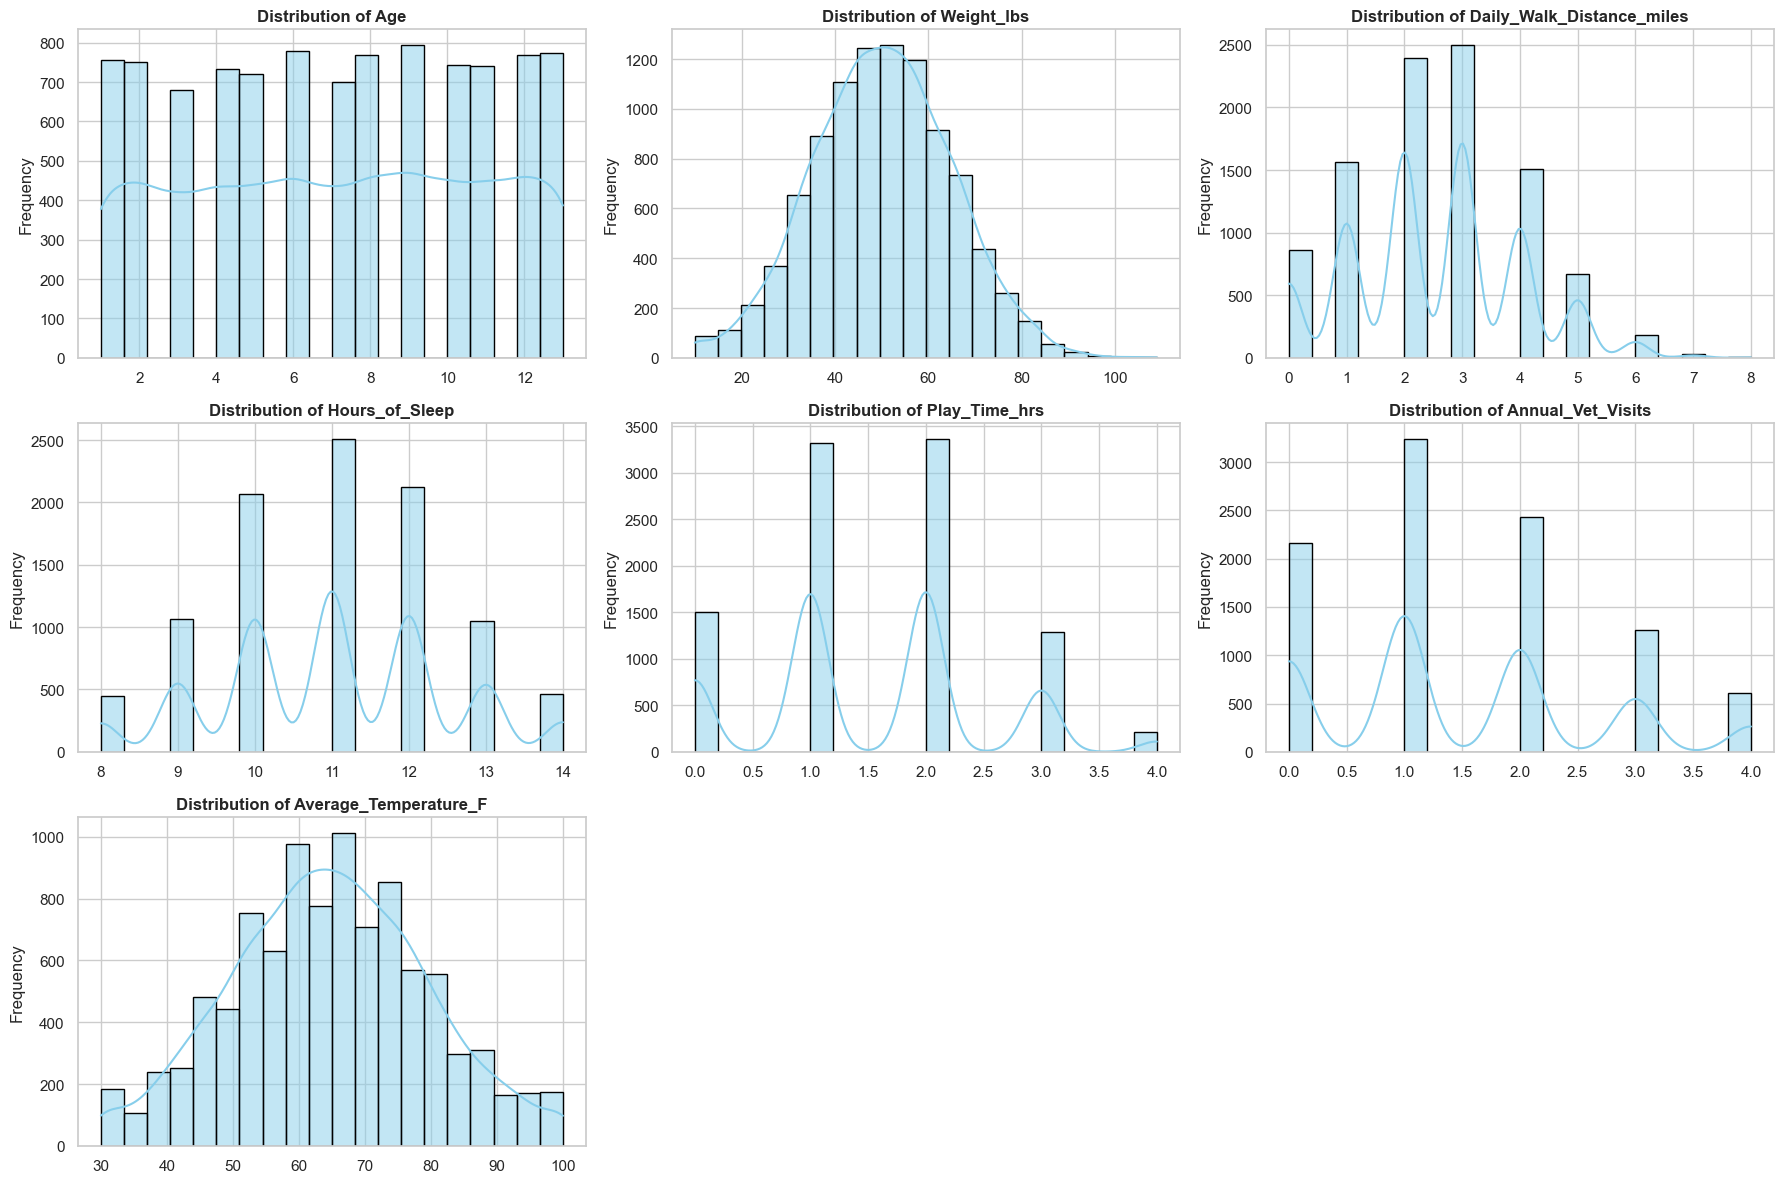

In [12]:
import math


# List of numerical columns
num_cols = ['Age', 'Weight_lbs', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
            'Play_Time_hrs', 'Annual_Vet_Visits', 'Average_Temperature_F']


# Grid configuration (dynamic rows and columns)
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)


plt.figure(figsize=(18, 4 * n_rows))
sns.set_theme(style="whitegrid")


for i, col in enumerate(num_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Option A: Histogram with density curve (KDE)
    sns.histplot(data=df, x=col, kde=True, color="skyblue", edgecolor="black", bins=20)
    
    plt.title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    plt.xlabel('')  # Clear x label to avoid clutter
    plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

In [13]:
num_cols_disc = ['Age', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
            'Play_Time_hrs', 'Annual_Vet_Visits']

for i in num_cols_disc:
    print(i, df[i].unique())

Age [ 3.  4. 12. 13.  2.  8. 11. nan  5. 10.  7.  9.  6.  1.]
Daily_Walk_Distance_miles [ 5.  2.  1.  4.  3.  0. nan  6.  7.  8.]
Hours_of_Sleep [12. 11. 10.  9.  8. 13. 14. nan]
Play_Time_hrs [ 1.  3. nan  2.  0.  4.]
Annual_Vet_Visits [ 1.  0.  2.  4. nan  3.]


We can see in the graphs that:

- We have normal distributions in the Weight_lbs and Average_Temperature_F attributes. Therefore, to handle null values, it would be best practice to use imputation by the mean, as this would be a better estimator.
- For the attributes Daily_Walk_Distance_miles, Hours_of_Sleep, Play_Time_hrs, Annual_Vet_Visits, and Age, we observe a non-normal distribution, which is flat in the case of the Age attribute and discrete variables with defined peaks for the other attributes. Because of this, imputation by the median would be the best option.

**Pre-Processing (Split and Imputation) and Training**

First, we analyze the distribution of classes to determine whether we need balancing, and we calculate the majority class error to determine the baseline for the models to be trained.

Majority class error: 65.17135692393424 %


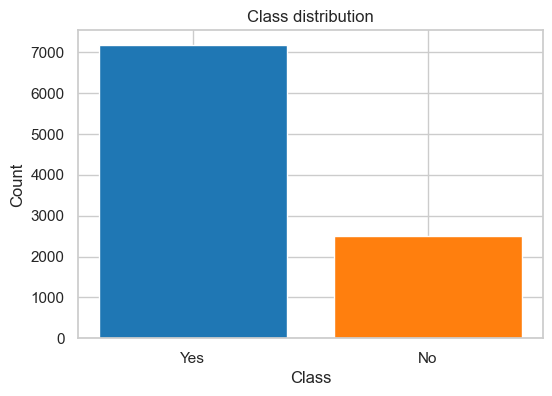

In [14]:
# Analyze the error of the minority class

Yes_class = df['Healthy'].value_counts().iloc[0]
No_class = df['Healthy'].value_counts().iloc[1]

error_class = 1 - (No_class/Yes_class)
print('Majority class error:', error_class*100, "%")

# Requested colors
colores = ['#1f77b4', '#ff7f0e']

# Class distribution plot
plt.figure(figsize=(6,4))
plt.bar(conteo.index, conteo.values, color=colores)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class distribution')
plt.show()

We can see that we do not have a very large imbalance, so we will not need any balancing.

Now we apply the pre-processing following the imputation strategy mentioned above.

Training (80%): (7742, 17)
Validation (5%):    (484, 17)
Test (15%):   (1452, 17)

⏳ Benchmark with n = 200 samples...

⏳ Benchmark with n = 400 samples...

⏳ Benchmark with n = 800 samples...

⏳ Benchmark with n = 7742 samples...


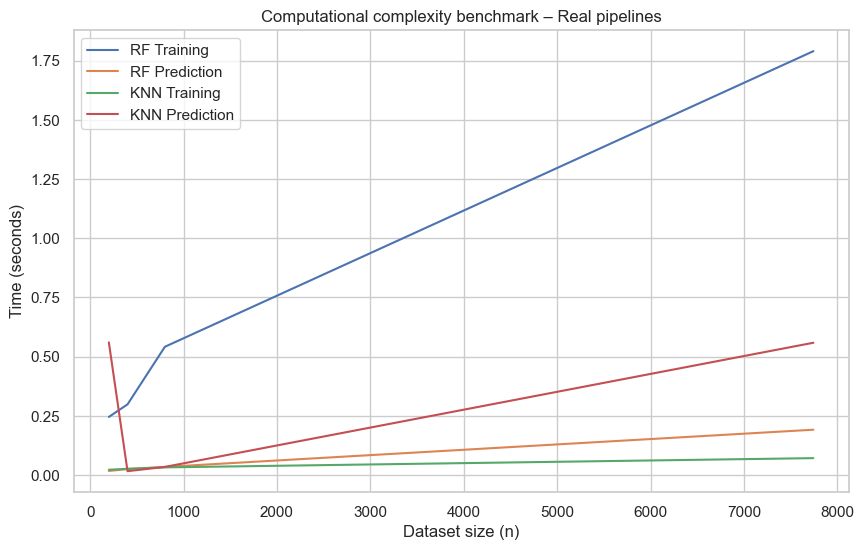

In [15]:
from scipy.stats import wilcoxon  # <--- New library for the test
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report



# ==========================================
# STEP 0: INITIAL LOADING AND CLEANING
# ==========================================
# We assume that 'df' is already loaded
# Remove rows where the target variable 'Healthy' is null
df_clean = df.dropna(subset=['Healthy']).copy()

# Separate Features (X) and Target (y)

X = df_clean.drop('Healthy', axis=1)
y = df_clean['Healthy']


# ==========================================
# STEP 1: DATA SPLIT (80% Train / 10% Val / 10% Test)
# ==========================================
# First split: 80% Train vs 20% Temporary
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# We will use the validation set as test data during deployment
# Second split: Split the 20% temporary set into two parts (15% test + 5% val)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.75, random_state=42, stratify=y_temp
)

print(f"Training (80%): {X_train.shape}")
print(f"Validation (5%):    {X_val.shape}")
print(f"Test (15%):   {X_test.shape}")


# ==========================================
# STEP 2: COLUMN STRATEGY
# ==========================================
cols_normales = ['Weight_lbs', 'Average_Temperature_F']
cols_sesgadas = ['Age', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
                 'Play_Time_hrs', 'Annual_Vet_Visits']
cols_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()


# ==========================================
# STEP 3 AND 4: PREPROCESSORS AND PIPELINES
# ==========================================
# For numerical attributes with normal distribution: Apply mean imputation.
# For numerical attributes with non-normal distribution: Apply median imputation.
# For categorical attributes: Mode imputation. 


# --- KNN PREPROCESSOR ---
preprocessor_knn = ColumnTransformer([
    ('num_normal', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()) 
    ]), cols_normales),
    ('num_sesgada', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) 
    ]), cols_sesgadas),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])


# --- RF PREPROCESSOR ---
preprocessor_rf = ColumnTransformer([
    ('num_normal', SimpleImputer(strategy='mean'), cols_normales),
    ('num_sesgada', SimpleImputer(strategy='median'), cols_sesgadas),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])


# --- PIPELINES ---
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])


pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ))
])

# ==========================================
# BENCHMARK ADAPTED TO YOUR PIPELINES
# ==========================================
import time

# We are going to evaluate time for different training set sizes
sizes = [200, 400, 800, len(X_train)]  # Adjustable depending on your dataset

rf_train_times = []
rf_pred_times = []
knn_train_times = []
knn_pred_times = []

for n in sizes:
    print(f"\n⏳ Benchmark with n = {n} samples...")

    X_subset = X_train.iloc[:n]
    y_subset = y_train.iloc[:n]

    # ===== RANDOM FOREST =====
    start = time.time()
    pipeline_rf.fit(X_subset, y_subset)
    rf_train_times.append(time.time() - start)

    start = time.time()
    pipeline_rf.predict(X_subset)
    rf_pred_times.append(time.time() - start)

    # ===== KNN =====
    start = time.time()
    pipeline_knn.fit(X_subset, y_subset)
    knn_train_times.append(time.time() - start)

    start = time.time()
    pipeline_knn.predict(X_subset)
    knn_pred_times.append(time.time() - start)


# ==========================================
# BENCHMARK PLOT
# ==========================================
plt.figure(figsize=(10,6))
plt.plot(sizes, rf_train_times, label="RF Training")
plt.plot(sizes, rf_pred_times, label="RF Prediction")
plt.plot(sizes, knn_train_times, label="KNN Training")
plt.plot(sizes, knn_pred_times, label="KNN Prediction")

plt.xlabel("Dataset size (n)")
plt.ylabel("Time (seconds)")
plt.title("Computational complexity benchmark – Real pipelines")
plt.legend()
plt.grid(True)
plt.show()

We verify whether there are significant differences between models.

In [16]:
# ==========================================
# STEP 5: STATISTICAL EVALUATION (MODIFIED)
# ==========================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def obtener_scores_cv(pipeline, X, y, nombre):
    print(f"\n--- Evaluating {nombre} (5 Folds) ---")
    # We use accuracy for the Wilcoxon test (it is more robust to compare pure accuracy)
    # But we print F1 for your reference regarding class imbalance
    acc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted')
    
    print(f"Average Accuracy: {acc_scores.mean():.4f} (+/- {acc_scores.std()*2:.4f})")
    print(f"Average F1-Score: {f1_scores.mean():.4f}")
    
    # Return FULL ARRAY of scores for the statistical test
    return acc_scores 


# 1. Get the result arrays (5 numbers each)
scores_knn = obtener_scores_cv(pipeline_knn, X_train, y_train, "KNN")
scores_rf = obtener_scores_cv(pipeline_rf, X_train, y_train, "Random Forest")


--- Evaluating KNN (5 Folds) ---
Average Accuracy: 0.8223 (+/- 0.0097)
Average F1-Score: 0.8029

--- Evaluating Random Forest (5 Folds) ---
Average Accuracy: 0.9286 (+/- 0.0077)
Average F1-Score: 0.9260


Differences per fold (KNN - RF): [-0.10974822 -0.10716591 -0.10400517 -0.10529716 -0.10529716]
Average difference: -0.1063027242715564


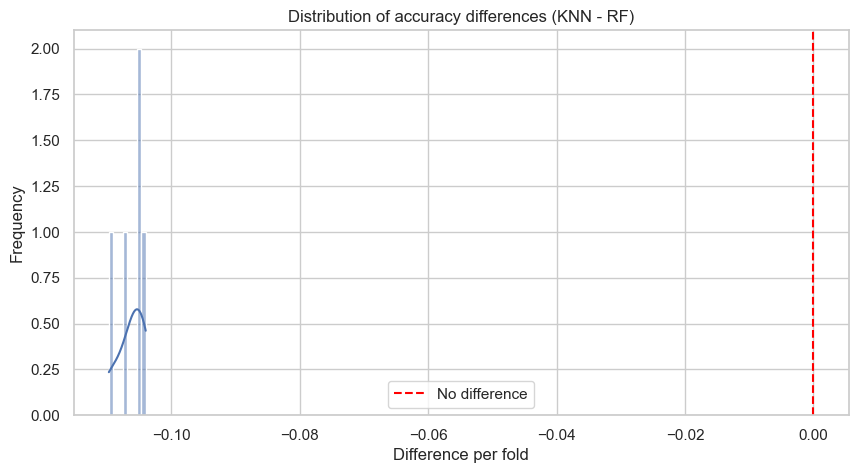

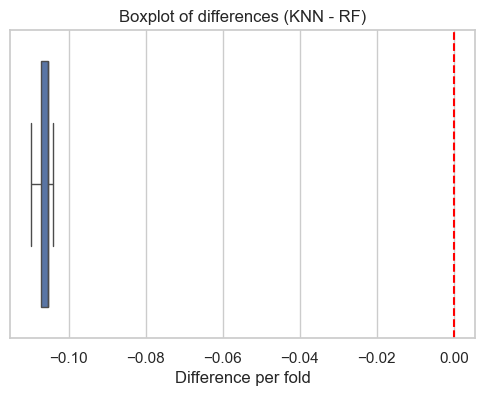

In [17]:
# ==========================================
# STEP 6: DISPLAY OF DISTRIBUTION
# ==========================================

# 1. Calculate paired differences
diffs = scores_knn - scores_rf

print("Differences per fold (KNN - RF):", diffs)
print("Average difference:", diffs.mean())

# 2. Plot: Histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(diffs, kde=True, bins=8)
plt.axvline(0, color='red', linestyle='--', label="No difference")
plt.title("Distribution of accuracy differences (KNN - RF)")
plt.xlabel("Difference per fold")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 3. Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=diffs)
plt.axvline(0, color='red', linestyle='--')
plt.title("Boxplot of differences (KNN - RF)")
plt.xlabel("Difference per fold")
plt.show()

In [18]:
# 2. Apply Wilcoxon Test
print("\n========================================")
print("🧪 SIGNIFICANCE TEST (WILCOXON)")
print("========================================")

# Compare arrays: Are they systematically different?
stat, p_value = wilcoxon(scores_rf, scores_knn)

print(f"KNN results per fold: {np.round(scores_knn, 4)}")
print(f"RF results per fold:  {np.round(scores_rf, 4)}")
print(f"Wilcoxon statistic W: {stat}, P-Value: {p_value:.5f}")

# Automatic interpretation
alpha = 0.05
diferencia_significativa = p_value < alpha

if diferencia_significativa:
    print("\n✅ RESULT: There is a STATISTICALLY SIGNIFICANT difference.")
    if scores_rf.mean() > scores_knn.mean():
        ganador = "Random Forest"
        modelo_ganador = pipeline_rf
    else:
        ganador = "KNN"
        modelo_ganador = pipeline_knn
    print(f"The {ganador} model is superior with 95% confidence.")
else:
    print("\n❌ RESULT: There is NO significant difference between the models.")
    print("Both perform equally well (statistically).")
    # In case of a tie, choose Random Forest as it is generally more robust in production
    # or the one with the best simple arithmetic mean.
    if scores_rf.mean() >= scores_knn.mean():
        ganador = "Random Forest (By simple mean)"
        modelo_ganador = pipeline_rf
    else:
        ganador = "KNN (By simple mean)"
        modelo_ganador = pipeline_knn



🧪 SIGNIFICANCE TEST (WILCOXON)
KNN results per fold: [0.8173 0.8231 0.8307 0.8178 0.8224]
RF results per fold:  [0.927  0.9303 0.9348 0.9231 0.9276]
Wilcoxon statistic W: 0.0, P-Value: 0.06250

❌ RESULT: There is NO significant difference between the models.
Both perform equally well (statistically).


We saw that there is no statistically significant difference between models. The Random Forest model has the lowest computational prediction cost.

In [19]:
# ==========================================
# STEP 6: TRAINING AND EVALUATION ON VALIDATION SET
# ==========================================
print(f"\n🏆 SELECTED MODEL: {ganador}")
print("Training final model with the WHOLE Train set...")
modelo_ganador.fit(X_train, y_train)


# Intermediate evaluation with VALIDATION (to tune hyperparameters if needed)
print("\n--- Evaluation on VALIDATION SET (For tuning) ---")
y_pred_val = modelo_ganador.predict(X_val)
print(classification_report(y_val, y_pred_val))


# ==========================================
# STEP 7: FINAL EVALUATION ON TEST (Only once at the end of the project)
# ==========================================
print("\n--- 🔒 Final Evaluation on TEST SET (Never-seen data) ---")
y_pred_test = modelo_ganador.predict(X_test)
print(classification_report(y_test, y_pred_test))



🏆 SELECTED MODEL: Random Forest (By simple mean)
Training final model with the WHOLE Train set...

--- Evaluation on VALIDATION SET (For tuning) ---
              precision    recall  f1-score   support

          No       0.97      0.78      0.86       125
         Yes       0.93      0.99      0.96       359

    accuracy                           0.94       484
   macro avg       0.95      0.88      0.91       484
weighted avg       0.94      0.94      0.93       484


--- 🔒 Final Evaluation on TEST SET (Never-seen data) ---
              precision    recall  f1-score   support

          No       0.95      0.77      0.85       375
         Yes       0.93      0.99      0.95      1077

    accuracy                           0.93      1452
   macro avg       0.94      0.88      0.90      1452
weighted avg       0.93      0.93      0.93      1452



We also evaluate the performance of the KNN.

In [20]:
# ==========================================
# STEP 6: TRAINING AND EVALUATION ON VALIDATION SET
# ==========================================
print(f"\n KNN EVALUATION")
print("Training final model with the WHOLE Train set...")
pipeline_knn.fit(X_train, y_train)


# Intermediate evaluation with VALIDATION (to tune hyperparameters if needed)
print("\n--- Evaluation on VALIDATION SET (For tuning) ---")
y_pred_val = pipeline_knn.predict(X_val)
print(classification_report(y_val, y_pred_val))


# ==========================================
# STEP 7: FINAL EVALUATION ON TEST (Only once at the end of the project)
# ==========================================
print("\n--- 🔒 Final Evaluation on TEST SET (Never-seen data) ---")
y_pred_test = pipeline_knn.predict(X_test)
print(classification_report(y_test, y_pred_test))



 KNN EVALUATION
Training final model with the WHOLE Train set...

--- Evaluation on VALIDATION SET (For tuning) ---
              precision    recall  f1-score   support

          No       0.74      0.41      0.53       125
         Yes       0.82      0.95      0.88       359

    accuracy                           0.81       484
   macro avg       0.78      0.68      0.70       484
weighted avg       0.80      0.81      0.79       484


--- 🔒 Final Evaluation on TEST SET (Never-seen data) ---
              precision    recall  f1-score   support

          No       0.79      0.44      0.57       375
         Yes       0.83      0.96      0.89      1077

    accuracy                           0.83      1452
   macro avg       0.81      0.70      0.73      1452
weighted avg       0.82      0.83      0.81      1452



**RESULTS**

| Metric             | Random Forest | KNN      | Best model    |
| ------------------- | ------------- | -------- | --------------- |
| **Accuracy**        | **0.94**      | 0.81     | RF              |
| **Precision (No)**  | **0.97**          | 0.74     | RF              |
| **Precision (Yes)** | **0.93**      | 0.82     | RF              |
| **Recall (No)**     | **0.78**      | 0.41     | RF              |
| **Recall (Yes)**    | 0.99          | 0.95 | RF (casi igual) |
| **F1 (No)**         | **0.86**          | 0.53     | RF              |
| **F1 (Yes)**        | **0.96**          | 0.88     | RF              |
| **Macro F1**        | **0.91**      | 0.70     | RF              |
| **Weighted F1**     | **0.93**      | 0.79     | RF              |


We can see that the Random Forest model performed better overall, while KNN had particular difficulty correctly identifying cases in the minority class (Recall = No).

Given that the Random Forest model performed better in predicting values and also had a lower computational cost for prediction, we selected this model for production.

In [21]:
# We verify the importance of each variable in the prediction.
rf = pipeline_rf.named_steps["classifier"]
importances = rf.feature_importances_

# Names after preprocessing
feature_names = pipeline_rf.named_steps["preprocessor"].get_feature_names_out()

for name, imp in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(name, imp)


num_sesgada__Age 0.11008561170357642
num_sesgada__Annual_Vet_Visits 0.08862744515958305
cat__SpayNeuter_Status_Unknown 0.07431033100457607
cat__Medications_Yes 0.05768636635095536
cat__Medications_No 0.05417539955187715
num_normal__Weight_lbs 0.05261291698955995
num_normal__Average_Temperature_F 0.04027583755502344
cat__Daily_Activity_Level_Very_Active 0.03623563205839327
cat__Daily_Activity_Level_Active 0.033982376125767794
cat__Diet_Special_diet 0.032402364174523086
num_sesgada__Daily_Walk_Distance_miles 0.024736986211998307
num_sesgada__Hours_of_Sleep 0.02341467335742704
cat__Food_Brand_Special 0.022734996138415547
cat__Diet_Home_cooked 0.02179532718874725
cat__SpayNeuter_Status_Spayed 0.020181384554406878
cat__SpayNeuter_Status_Neutered 0.01986255694054913
cat__Diet_Wet_food 0.018891412553503913
num_sesgada__Play_Time_hrs 0.018543453833278774
cat__Diet_Hard_food 0.01800930139910157
cat__Seizures_Yes 0.016589883450445837
cat__Seizures_No 0.01542727805853125
cat__Daily_Activity_Level

In [22]:
# ==========================================
# STEP 8: SAVE MODEL FOR DEPLOY (JOBLIB)
# ==========================================
import joblib
import os

# Folder where the model will be saved
os.makedirs("model_artifacts", exist_ok=True)

# Destination file
model_path = "model_artifacts/random_forest_pipeline.pkl"

joblib.dump(modelo_ganador, model_path)

print(f"\n📦 Model successfully saved to: {model_path}")


📦 Model successfully saved to: model_artifacts/random_forest_pipeline.pkl


**Deploy**

The deployment strategy we are going to use is a local deployment using containers. For more information, see the links:

https://medium.com/@victormacedo996/estrat%C3%A9gias-de-deploy-de-modelos-online-de-ml-parte-1-a45d648c68a7

https://www.reddit.com/r/mlops/comments/17akbyn/ml_model_deployment_a_practical_3part_guide/?tl=es-419

Deploying a Machine Learning model — Getting started:

https://medium.com/@TejasEkawade/deploying-a-machine-learning-model-getting-started-2644392c8953

Deploying a Machine Learning Model: Part 2 — Local Deployment:

https://medium.com/@TejasEkawade/deploying-a-machine-learning-model-part-2-local-deployment-1c36d029ce7a





In [23]:
# We save the model metadata with mlem.api

from mlem.api import save

# We save the model and indicate the data structure with sample_data.
save(modelo_ganador, "model_artifacts/RF", sample_data=X_train)

MlemModel(location=Location(path='d:/Archivos/Maestria/IML/Trabalho 2/model_artifacts/RF.mlem', project=None, rev=None, uri='file://d:/Archivos/Maestria/IML/Trabalho 2/model_artifacts/RF.mlem', project_uri=None, fs=<fsspec.implementations.local.LocalFileSystem object at 0x000001A790AD6D50>), params={}, artifacts={'data': LocalArtifact(uri='RF', size=17592240, hash='fc2c6efa99ccfe1bc7f22b3c331a32e1')}, requirements=Requirements(__root__=[InstallableRequirement(module='numpy', version='2.2.6', package_name=None, extra_index=None, source_url=None, vcs=None, vcs_commit=None), InstallableRequirement(module='pandas', version='2.2.2', package_name=None, extra_index=None, source_url=None, vcs=None, vcs_commit=None), InstallableRequirement(module='sklearn', version='1.5.2', package_name='scikit-learn', extra_index=None, source_url=None, vcs=None, vcs_commit=None)]), processors_cache={'model': SklearnPipelineType(model=Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transform

We first tested the prediction with joblib (faster).

In [24]:
# Load model
modelo = joblib.load("model_artifacts/random_forest_pipeline.pkl")

# ====================================
# TAKE ONE ROW FROM X_val TO PREDICT
# ====================================
fila = 10  # <---- you can change the row you want to use
example = X_val.iloc[[fila]]  # important to use [[ ]] to keep a DataFrame

#print("Row used for prediction:")
#print(example)

# ====================================
# PREDICTION
# ====================================
pred = modelo.predict(example)
proba = modelo.predict_proba(example)

print("\nPrediction:", pred[0])
print("Probabilities:", proba[0])


Prediction: Yes
Probabilities: [0.18 0.82]


Now we test the model with mlem, which will help us to deploy it.

In [25]:
from mlem.api import load

model = load("model_artifacts/RF")  # RandomForestClassifier
features = [
    "Breed",
    "Sex",
    "Age",
    "Weight_lbs",
    "SpayNeuter_Status",
    "Daily_Activity_Level",
    "Diet",
    "Food_Brand",
    "Daily_Walk_Distance_miles",
    "Other_Pets_in_Household",
    "Medications",
    "Seizures",
    "Hours_of_Sleep",
    "Play_Time_hrs",
    "Owner_Activity_Level",
    "Annual_Vet_Visits",
    "Average_Temperature_F",
]

#example = pd.DataFrame([[0, 1, 2, 3]], columns=features)  # we can also manually provide the values

# We use the X_val values to test the model
fila = 10  # <---- you can change the row you want to use
example = X_val.iloc[[fila]]  # important to use [[ ]] to keep a DataFrame
y_pred = model.predict(example)
y_pred_proba = model.predict_proba(example)

print("Result (Healthy?) = ", y_pred)
print("Probability", y_pred_proba)

Result (Healthy?) =  ['Yes']
Probability [[0.18 0.82]]


Here are the following steps for deploying a model locally:

- Set up a virtual environment and install the required packages
- Build and save the model
- Serve the model locally
- Create a folder structure for files
- Build a docker image
- Spin up a container to run the application
- Test the model endpoint

| Stage                   | Details                                                                   |
| ----------------------- | ------------------------------------------------------------------------- |
| Development Environment | Virtual Environment, Python packages: pandas, scikit-learn, mlem[fastapi] |
| Model Development       | Random Forest Classifier, Training on Iris Dataset, scikit-learn          |
| Model Packaging         | MLEM Library, Model Serialization, Metadata (.mlem file)                  |
| Local Serving           | MLEM + FastAPI Server, REST API Endpoint, Port: 8080                      |
| Containerization        | Docker Build, Dockerfile + requirements.txt, Docker Image                 |
| Deployment              | Docker Container, Running Application, Port Mapping 8080:8080             |
| Testing & Interface     | Swagger UI, API Endpoint Testing, predict_proba endpoint                  |

**To run the model trained in this project execute docker and spin up a container to run the docker image.**

Enter the project folder and run from the terminal:

docker run -p 8080:8080 mlem-model:latest

Once the container is runing you can acces the model in the next link:

http://localhost:8080/docs

The model is available for use. Access the default functions (predict or predict_proba) and try it out. Fill the predictors and get the class predicted in predict and the probability associated with each predicted class in predict_proba